In [1]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm as univariate_normal
import numpy as np
import pandas as pd
import seaborn as sns
import math
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
class BayesianLinearRegression:
    
    def __init__(self, prior_mean, prior_cov, noise_var,poly_degree=1):
        self.prior_mean = prior_mean[:, np.newaxis] # column vector of shape (1, d)
        self.prior_cov = prior_cov # matrix of shape (d, d)
        # We initalize the prior distribution over the parameters using the given mean and covariance matrix
        # In the formulas above this corresponds to w_0 (prior_mean) and V_0 (prior_cov)
        self.prior = multivariate_normal(prior_mean, prior_cov)
        
        # We also know the variance of the noise (assumption) - valid here as we are only concerned with the prediction value
        self.noise_var = noise_var # single float value
        self.noise_precision = 1 / noise_var
        
        # Before performing any inference the parameter posterior equals the parameter prior
        self.param_posterior = self.prior
        # Accordingly, the posterior mean and covariance equal the prior mean and variance
        self.post_mean = self.prior_mean # corresponds to w_N in formulas
        self.post_cov = self.prior_cov # corresponds to V_N in formulas
        self.n = poly_degree
        self.poly = None
        
    def update_posterior(self, features, targets):
        
        # target should be (N, 1)
        # Compute the design matrix, shape (N, 5)
        design_matrix = self.compute_design_matrix(features)

        # Update the covariance matrix, shape (5, 5)
        design_matrix_dot_product = design_matrix.T.dot(design_matrix)
        inv_prior_cov = np.linalg.inv(self.prior_cov)
        self.post_cov = np.linalg.inv(inv_prior_cov +  self.noise_precision * design_matrix_dot_product)
        
        # Update the mean, shape (5, 1)
        self.post_mean = self.post_cov.dot( inv_prior_cov.dot(self.prior_mean) + self.noise_precision * design_matrix.T.dot(targets))
        
        # Update the posterior distribution
        self.param_posterior = multivariate_normal(self.post_mean.flatten(), self.post_cov, allow_singular=True)
                
    def compute_design_matrix(self, features): 
        """
        compute_design_matrix(np.array([2, 3]))
        np.array([[1., 2.], [1., 3.])
        """
        n_samples = np.shape(features)[0]
        # we will use poly reg of order n
        if self.poly==None:
            poly = PolynomialFeatures(degree = self.n, interaction_only=False, include_bias=False)
            self.poly = poly
        else:
            poly = self.poly
        features_poly = poly.fit_transform(features)
        phi_0 = np.ones(n_samples).reshape(-1,1)
#         design_matrix = np.stack((phi_0, features_poly), axis=1)
        design_matrix = np.hstack((phi_0, features_poly))
        return design_matrix
    
 
    def predict(self, features):
        design_matrix = self.compute_design_matrix(features)
        
        pred_mean = design_matrix.dot(self.post_mean)
        pred_cov = design_matrix.dot(self.post_cov.dot(design_matrix.T)) + self.noise_var
        
        pred_posterior = univariate_normal(loc=pred_mean.flatten(), scale=pred_cov**0.5)
        return pred_posterior
    
def predict(X_test,X_test_id,model):
    result = np.array([]) # [id, X_test, pred]
    X_test.tolist()
    for i,elem in enumerate(X_test):
        temp1 = X_test_id[i]
        temp2 = elem
        temp3 = model.predict(np.array([elem]))
        temp3 = temp3.mean()[0][0]
        temp = np.array([temp1, temp2, temp3])
        if(np.size(result)==0):
            result = temp
        else:
            result = np.vstack((result,temp))
    if(X_test.size==1):
        result = np.reshape(result,(1,3))
    return result

def find_num_terms_poly(num_best_features,n):
    res = math.comb(num_best_features+n,n) - 1    #(num_best_features+n)Cn - 1
    return res

In [3]:
# customer churn dataset
df = pd.read_csv(r'C:\Users\vidha\Desktop\IISc\CP218 - Theory and applications of bayesian learning\Project2\Datasets\Iranian-Churn-Dataset-Data-Set\Customer Churn.csv')
print(df)

      Call Failure  Complains  Subscription Length  Charge Amount  \
0                8          0                   38              0   
1                0          0                   39              0   
2               10          0                   37              0   
3               10          0                   38              0   
4                3          0                   38              0   
...            ...        ...                  ...            ...   
3145            21          0                   19              2   
3146            17          0                   17              1   
3147            13          0                   18              4   
3148             7          0                   11              2   
3149             8          1                   11              2   

      Seconds of Use  Frequency of use  Frequency of SMS  \
0               4370                71                 5   
1                318                 5             

In [4]:
# customer churn datset
df.corr()['Customer Value']

Call Failure               0.121225
Complains                 -0.132895
Subscription Length        0.109565
Charge Amount              0.169428
Seconds of Use             0.415087
Frequency of use           0.401572
Frequency of SMS           0.924877
Distinct Called Numbers    0.284807
Age Group                 -0.183481
Tariff Plan                0.252298
Status                    -0.412990
Age                       -0.220362
Customer Value             1.000000
Churn                     -0.289144
Name: Customer Value, dtype: float64

In [5]:
# customer churn dataset
df_selected = df[['Call Failure', 'Subscription Length', 'Charge Amount', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value']]

In [6]:
df_selected.head()

,Call Failure,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Customer Value
0,8,38,0,4370,71,5,17,197.640
1,0,39,0,318,5,7,4,46.035
2,10,37,0,2453,60,359,24,1536.520
3,10,38,0,4198,66,1,35,240.020
4,3,38,0,2393,58,2,33,145.805


In [7]:
print("correlation of features with output :")
print(df_selected.corr()['Customer Value'])
columns = list(df_selected.columns)
corr_list = list(abs(df_selected.corr()['Customer Value']))[0:-1]
array_selected = df_selected.values
input_idx = [i for i in range(len(columns) - 1)]
output_idx = [input_idx[-1] + 1]

correlation of features with output :
Call Failure               0.121225
Subscription Length        0.109565
Charge Amount              0.169428
Seconds of Use             0.415087
Frequency of use           0.401572
Frequency of SMS           0.924877
Distinct Called Numbers    0.284807
Customer Value             1.000000
Name: Customer Value, dtype: float64


In [8]:
X = array_selected[:,input_idx]
y = array_selected[:,output_idx].astype('int')

In [9]:
def choose_features(num_of_features_choosen):
    temp1 = list(np.argsort(corr_list)[::-1][:num_best_features])
    temp2 = [input_idx[val] for val in temp1]
    choosen_features = [columns[val] for val in temp2]
    return choosen_features

In [10]:
MAX_DEGREE = 7
num_best_features_list = [i for i in range(1,len(columns))]
n_list = [i for i in range(1,MAX_DEGREE + 1)] # degree list
for num_best_features in num_best_features_list:
    choosen_features = choose_features(num_best_features)
    print("\nchoosen features :\n",choosen_features)
    input_features = np.array(df_selected[choosen_features]).reshape(-1,len(choosen_features))
    output_features = np.array(df_selected[['Customer Value']]).reshape(-1,1)

    X_train, X_test, y_train, y_test = train_test_split(input_features, output_features, test_size = 0.25)

    scaler = MinMaxScaler()
    # transform data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.fit_transform(y_test)
    noise_std_dev = 0.5
    noise_var = noise_std_dev**2
    lower_bound = -5
    upper_bound = 40
    for n in n_list:        
        # Initialize BLR model
        total_num_features = find_num_terms_poly(num_best_features,n) + 1
        prior_mean = np.array(total_num_features*[0.1])
        prior_cov = 1/2 * np.identity(total_num_features)
        
        # bayesian regression
        predicted_ys = []
        blr = BayesianLinearRegression(prior_mean, prior_cov, noise_var, poly_degree=n)

        blr.update_posterior(X_train_scaled, y_train_scaled)

        for elem in X_test_scaled:
            elem = np.array(elem).reshape(1,-1)
            pred_posterior = blr.predict(elem)
            predicted_y = pred_posterior.mean()
            predicted_ys.append(predicted_y[0][0])
            
        y_pred = np.array(predicted_ys).reshape(len(predicted_ys),1)

        print(f"R2 score with degree = {n} is {r2_score(y_test_scaled, y_pred)}")

        scaled_rmse = np.sqrt(mean_squared_error(y_test_scaled,y_pred))
        print(f"scaled rmse with degree {n} is : {scaled_rmse}")

        y_pred = scaler.inverse_transform(y_pred)
        actual_rmse = np.sqrt(mean_squared_error(y_test,y_pred))
        print(f"scaled rmse with degree {n} is : {actual_rmse}")


choosen features :
 ['Frequency of SMS']
R2 score with degree = 1 is 0.8837234593755343
scaled rmse with degree 1 is : 0.08598901308730696
scaled rmse with degree 1 is : 184.81446604828713
R2 score with degree = 2 is 0.8956220695323922
scaled rmse with degree 2 is : 0.08147066366540665
scaled rmse with degree 2 is : 175.1032680027852
R2 score with degree = 3 is 0.8958730982610418
scaled rmse with degree 3 is : 0.0813726362937184
scaled rmse with degree 3 is : 174.8925797333631
R2 score with degree = 4 is 0.8958849281794148
scaled rmse with degree 4 is : 0.08136801376595698
scaled rmse with degree 4 is : 174.88264462689602
R2 score with degree = 5 is 0.8959477861140105
scaled rmse with degree 5 is : 0.08134344769016702
scaled rmse with degree 5 is : 174.8298452515222
R2 score with degree = 6 is 0.8961013343604077
scaled rmse with degree 6 is : 0.08128340689640004
scaled rmse with degree 6 is : 174.70080077429472
R2 score with degree = 7 is 0.8963747100815358
scaled rmse with degree 7 i

R2 score with degree = 3 is 0.972415210515804
scaled rmse with degree 3 is : 0.038819616063109
scaled rmse with degree 3 is : 83.43422441211891
R2 score with degree = 4 is 0.9748179374479526
scaled rmse with degree 4 is : 0.03709044535022051
scaled rmse with degree 4 is : 79.71775238232196
R2 score with degree = 5 is 0.9756784458680443
scaled rmse with degree 5 is : 0.03645121929939421
scaled rmse with degree 5 is : 78.34387661580199
R2 score with degree = 6 is 0.9752399651487365
scaled rmse with degree 6 is : 0.03677833163968691
scaled rmse with degree 6 is : 79.04693262654628
R2 score with degree = 7 is 0.9737557178140293
scaled rmse with degree 7 is : 0.03786463268378736
scaled rmse with degree 7 is : 81.38169773461051
R2 score with degree = 8 is 0.9716737660368766
scaled rmse with degree 8 is : 0.03933786791536479
scaled rmse with degree 8 is : 84.54809275313525
R2 score with degree = 9 is 0.9694166097264223
scaled rmse with degree 9 is : 0.0408751361444581
scaled rmse with degree 


KeyboardInterrupt



using pca

In [21]:
n = 1
num_best_features = 7
choosen_features = choose_features(num_best_features)
print("\nchoosen features :\n",choosen_features)
input_features = np.array(df_selected[choosen_features]).reshape(-1,len(choosen_features))
output_features = np.array(df_selected[['Customer Value']]).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(input_features, output_features, test_size = 0.25)

scaler = MinMaxScaler()
# transform data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.fit_transform(y_test)


choosen features :
 ['Frequency of SMS', 'Seconds of Use', 'Frequency of use', 'Distinct Called Numbers', 'Charge Amount', 'Call Failure', 'Subscription Length']


[0.52, 0.16, 0.13, 0.1, 0.05, 0.04, 0.01]


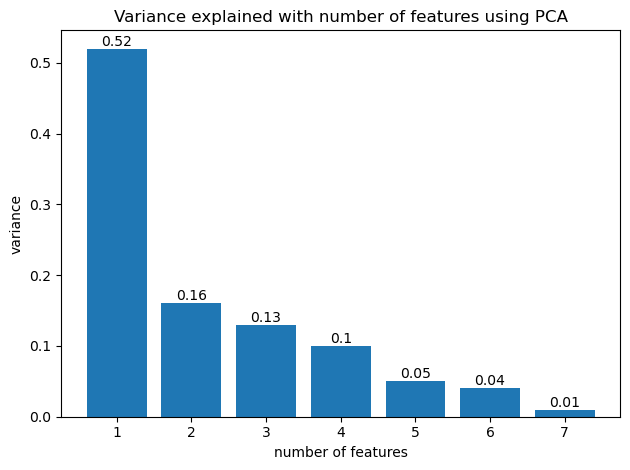

In [22]:
pca = PCA()
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance=[round(elem,2) for elem in explained_variance]
print(explained_variance)
x_bar = [i for i in range(1,len(explained_variance)+1)]
fig = plt.bar(x =x_bar, height=explained_variance)
plt.bar_label(labels=explained_variance,container=fig)

plt.title('Variance explained with number of features using PCA')
plt.xlabel("number of features")
plt.ylabel("variance")
plt.tight_layout()
plt.savefig("plots/variance_explained_pca_bayesian_regression.jpg",dpi=150)

R2 score with degree = 1 is 0.9612686945576104
scaled rmse with degree 1 is : 0.048763090937976844
scaled rmse with degree 1 is : 103.8427088606045
R2 score with degree = 2 is 0.9703484650868309
scaled rmse with degree 2 is : 0.04266617875589897
scaled rmse with degree 2 is : 90.85912097694332
R2 score with degree = 3 is 0.9738676479417737
scaled rmse with degree 3 is : 0.040054324229359756
scaled rmse with degree 3 is : 85.29708534776962
R2 score with degree = 4 is 0.9742949193180853
scaled rmse with degree 4 is : 0.03972552491258535
scaled rmse with degree 4 is : 84.59689569472243
R2 score with degree = 5 is 0.9743728018899385
scaled rmse with degree 5 is : 0.03966529804191929
scaled rmse with degree 5 is : 84.46864046569858
R2 score with degree = 6 is 0.9745380238827286
scaled rmse with degree 6 is : 0.03953722753067246
scaled rmse with degree 6 is : 84.19590982953056
R2 score with degree = 7 is 0.974734456916642
scaled rmse with degree 7 is : 0.039384422135832126
scaled rmse with d

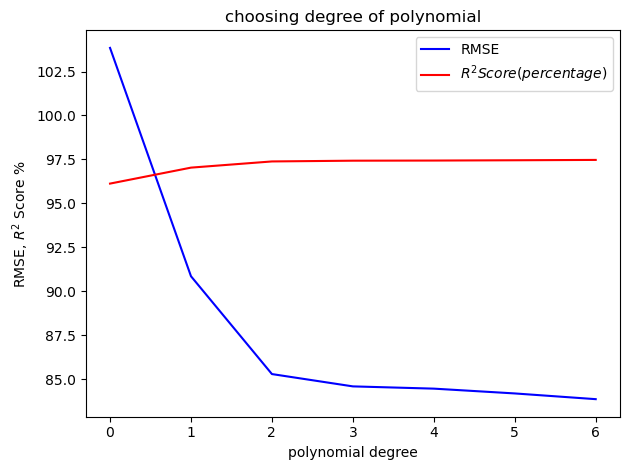

In [23]:
num_best_features = 4
pca = PCA(n_components=num_best_features)
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

MAX_DEGREE = 7
n_list = [i for i in range(1,MAX_DEGREE + 1)] # degree list
rmse_actual = []
r2_score_percent = []
for n in n_list:
    # Initialize BLR model
    total_num_features = find_num_terms_poly(num_best_features,n) + 1
    prior_mean = np.array(total_num_features*[0.1])
    prior_cov = 1/2 * np.identity(total_num_features)

    # bayesian regression
    predicted_ys = []
    blr = BayesianLinearRegression(prior_mean, prior_cov, noise_var, poly_degree=n)

    blr.update_posterior(X_train_scaled, y_train_scaled)

    for elem in X_test_scaled:
        elem = np.array(elem).reshape(1,-1)
        pred_posterior = blr.predict(elem)
        predicted_y = pred_posterior.mean()
        predicted_ys.append(predicted_y[0][0])

    y_pred = np.array(predicted_ys).reshape(len(predicted_ys),1)

    score = r2_score(y_test_scaled, y_pred)
    print(f"R2 score with degree = {n} is {score}")
    r2_score_percent.append(100*score)
    
    scaled_rmse = np.sqrt(mean_squared_error(y_test_scaled,y_pred))
    print(f"scaled rmse with degree {n} is : {scaled_rmse}")

    y_pred = scaler.inverse_transform(y_pred)
    actual_rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print(f"scaled rmse with degree {n} is : {actual_rmse}")
    rmse_actual.append(actual_rmse)

plt.plot(rmse_actual,'b-')
plt.plot(r2_score_percent,'r-')
plt.xlabel("polynomial degree")
plt.ylabel(r"RMSE, $R^2$ Score % ")

plt.title('choosing degree of polynomial')
plt.legend(['RMSE',r'$R^2 Score (percentage)$'])
plt.tight_layout()
plt.savefig("plots/polynomial_degree_pca_bayesian_regression.jpg",dpi=150)

plt.show()